In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from utilities import sample_edges, laplacian_distance
from filtering import low_pass_poly_coeffs, filter_distance, PolynomialGraphFilter
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Figure 1

In [2]:
n = 200 
m = 3 
repeats = 500
Ks = [1, 2, 3]

filters = {}
for K in Ks:
    coeffs = low_pass_poly_coeffs(K)
    filters[K] = PolynomialGraphFilter(coeffs)

data = []
for _ in tqdm(range(repeats)):

    # Generate the graph anf the perturbed graph
    G = nx.barabasi_albert_graph(n, m)
    r = int(np.random.rand()*G.number_of_edges())
    while r == 0:
        r = int(np.random.rand()*G.number_of_edges())
    edges_to_remove = sample_edges(G, r)
    Gp = G.copy()
    Gp.remove_edges_from(edges_to_remove)

    # graph and perturbation properties
    lap_dist = laplacian_distance(G, Gp)
    is_connected = nx.is_connected(Gp)
    num_isolates = len(list(nx.isolates(Gp)))

    # filter distance for different filters
    for K in Ks:
        data.append([lap_dist, is_connected, num_isolates, K, filter_distance(G, Gp, filters[K])])

df = pd.DataFrame(data, columns = ['lap_dist', 'is_connected', 'num_isolates', 'K', 'filter_dist'])
df = df.query('num_isolates==0')

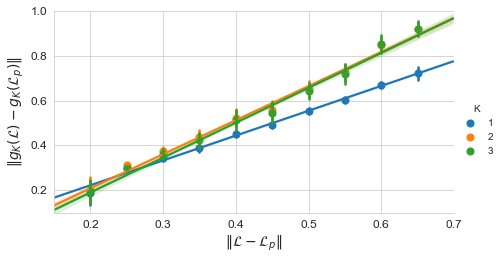

In [3]:
sns.set_style('whitegrid')
lm = sns.lmplot(x='lap_dist', y='filter_dist', hue='K', data=df, x_ci='sd', height=3.5, aspect=1.8, x_bins=np.arange(0.2, 0.7, 0.05))
ax = lm.axes[0][0]
ax.set_ylim(0.1,  1)
ax.set_xlim(0.15, 0.7)
ax.set_xlabel(r'$\left\Vert \mathcal{L}-\mathcal{L}_p \right\Vert$', fontsize=14)
ax.set_ylabel(r'$\left\Vert g_K(\mathcal{L})-g_K(\mathcal{L}_p) \right\Vert$', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('figures/linear.pdf', bbox_inches='tight')

# Figure 2

In [4]:
n = 500
m = 3
proportion = 0.05

def get_data(k, dataset):
    experiment_name = f'BA({n},{m})_{proportion}' if dataset == 'BA' else f'Sensor({n})_{proportion}'
    if k is not None:
        experiment_name = f'{experiment_name}_{k}'
    df = pd.read_csv(f'results/{experiment_name}.csv', index_col=0)
    df = df[['repeat', 'distance']].drop_duplicates()
    df['k'] = k
    return df

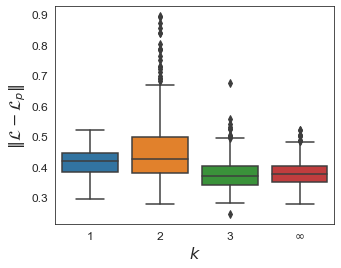

In [5]:
# BA
dfs = []
for k in [1,2,3,None]:
    dfs.append(get_data(k, 'BA'))
df = pd.concat(dfs, ignore_index=True)

sns.set_style('white')
fig, ax = plt.subplots(figsize=(5,4))
df['k'] = df['k'].replace({None : r'$\infty$'})
sns.boxplot(x='k', y='distance', data=df)
ax.set_ylabel(r'$\left\Vert \mathcal{L} - \mathcal{L}_p  \right\Vert$', fontsize=16)
ax.set_xlabel(r'$k$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(f'figures/BA.pdf', bbox_inches='tight')

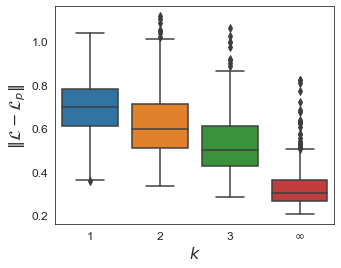

In [6]:
# Sensor
dfs = []
for k in [1, 2, 3, None]:
    dfs.append(get_data(k, 'Sensor'))
df = pd.concat(dfs, ignore_index=True)

fig, ax = plt.subplots(figsize=(5,4))
df['k'] = df['k'].replace({None : r'$\infty$'})
sns.boxplot(x='k', y='distance', data=df)
ax.set_ylabel(r'$\left\Vert \mathcal{L} - \mathcal{L}_p  \right\Vert$', fontsize=16)
ax.set_xlabel(r'$k$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(f'figures/Sensor.pdf', bbox_inches='tight')